# Project: Identify Customer Segments
In this project, I applied unsupervised learning techniques, mainly k-means, to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

These terms were used interchangeably in this project.
- Rows - Records. Entities, Members, etc.
- Columns - Features, Fields, Attributes, etc.


## Table of Contents
<ul>
<li><a href="#step_0">Step 0: Load the Data</a></li>
<li><a href="#step_1">Step 1: Preprocessing</a></li>
  <ul>
    <li><a href="#step_1_1">Step 1.1: Assess Missing Data</a></li>
      <ul>
        <li><a href="#step_1_1_1">Step 1.1.1: Convert Missing Value Codes to NaNs</a></li>
        <li><a href="#step_1_1_2">Step 1.1.2: Assess Missing Data in Each Column</a></li>
        <li><a href="#step_1_1_3">Step 1.1.3: Assess Missing Data in Each Row</a></li>
      </ul>
    <li><a href="#step_1_2">Step 1.2: Select and Re-Encode Features</a></li>
      <ul>
        <li><a href="#step_1_2_1">Step 1.2.1: Re-Encode Categorical Features</a></li>
        <li><a href="#step_1_2_2">Step 1.2.2: Engineer Mixed-Type Features</a></li>
        <li><a href="#step_1_2_3">Step 1.2.3: Complete Feature Selection</a></li>
      </ul>
    <li><a href="#step_1_3">Step 1.3: Create a Cleaning Function</a></li>
  </ul>
<li><a href="#step_2">Step 2: Feature Transformation</a></li>
  <ul>
    <li><a href="#step_2_1">Step 2.1: Apply Feature Scaling</a></li>
    <li><a href="#step_2_2">Step 2.2: Perform Dimensionality Reduction</a></li>
    <li><a href="#step_2_3">Step 2.3: Interpret Principal Components</a></li>
  </ul>
<li><a href="#step_3">Step 3: Clustering</a></li>
  <ul>
    <li><a href="#step_3_1">Step 3.1: Apply Clustering to General Population</a></li>
    <li><a href="#step_3_2">Step 3.2: Apply All Steps to the Customer Data</a></li>
    <li><a href="#step_3_3">Step 3.3: Compare Customer Data to Demographics Data</a></li>
  </ul>
<li><a href="#references">References</a></li>
</ul>

In [1]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## scikit-learn modules:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA    
from sklearn.preprocessing import LabelEncoder

import random
from scipy.stats import itemfreq, chisquare
from IPython.core.display import HTML

## Python built-ins:
from collections import Counter
import operator, re
import pprint as pp
import itertools

## Notebook Environment - Set the max display rows & columns:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Set base plotting style
plt.style.use('seaborn-ticks')

## Set base plotting size
plt.rcParams['figure.figsize'] = 12, 9

## Increase figure resolution for high dpi screens
%config InlineBackend.figure_format = 'retina'

## magic word for producing visualizations in notebook
%matplotlib inline

## <a id='step_0'></a> Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.
To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project. The delimiter is semicolon (`;`). I used [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call with `sep=";"` to delimit the text and read in the data properly.
I abstracted a few most commonly used procedures to functions. Once the dataset is loaded to dataframes, I collected them in a list and feeded these datafrems to my utility. These functions present the general structure of the dataset and feature summary file. So I gained some general familiarity about my data.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

## Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

## Gather target dataframes in a list:
DFs = [azdias, feat_info]

### <a id="define_functions"></a> Common Utilities
The following is a lit of tools I created for some of the most frquently performed operations in data analyses.

In [3]:
attrs = ['shape', "columns", "info", 'describe']  ## DF attributes to explore

simpAttrs = ['shape', "columns"]                  ## Simple Attributes
callAttrs = ['info', 'mean', 'describe', "head"]  ## Callable Attributes


## Categorical Attributes:
def descCatAttrs(df):
  '''Describe Categorical Attributes of a DataFrame'''
  return df.select_dtypes(exclude=["float64", "int64"]).describe()


## Uniqueness
def cntUniqValuesInCatAttrs(df):
  '''Count Unique Values in each Categorical Attribute'''
  return df.select_dtypes(exclude=['float64','int64']).apply(lambda x: len(x.unique().tolist()), axis = 0)

## Deal with NaN, Null on Columns:
def showAttrsNaNs(df):
  '''Detect Attribute (Columns) with Missing Values and show a count of NaN on that attribute; (Need Update;)'''
  return df.isna().sum(axis = 0)

def showAttrsNaNPCTL(df):
  '''Return a DF with Columns and their NaN percentil (pctl), i.e. rows w/ at least one NaN; Exclude those w/o NaN '''
  df_All = (df.isna().mean(axis = 0) * 100).sort_values(ascending=False)
  return df_All[df_All != 0]



### Assessing Missing Data in each Row:
def showEntitiesNaNs(df):
  '''Show Number of Rows (Entities)) with missing Attribute (Column) Values - show Count; (Need Update;) '''
  return df.isna().sum(axis = 1)

def showEntitiesNaNsMean(df):
  '''Show % of Rows (Entities)) with missing Attribute (Column) Values - show Count; (Need Update;) '''
  return df.isna().mean(axis = 1)

def showEntitiesNaNPCTL(df):
  '''Return a DF with rows and their NaN percentil (pctl), i.e. rows w/ at least one NaN; Exclude those w/o NaN '''
  df_All = (df.isna().mean(axis = 1) * 100).sort_values(ascending=False)
  return df_All[df_All != 0]


def extractEntitiesWMissingValues(df):
  '''Extract Rows (Entities) with missing values on any Attribute to a new DataFrame '''
  return df.loc[ df.isna().any(axis = 1)]

def removeEntitiesWMissingValues(df):
  '''Extract Rows (Entities) with missing values on any Attribute to a new DataFrame '''
  return df.loc[ ~df.isna().any(axis = 1)]


## Deal with Attributes, i.e. Columns:
def getColNames(df):
  '''Return a list of Attribute Names (Columns) in a DataFrame '''
  return [ col for col in df.columns]

def getNumAttrs(df):
  '''Return a DataFrame with Numerical Attributes'''
  return df.select_dtypes(include =['float64','int64'])

def getCatAttrs(df):
  '''Return a DataFrame with Categorical Attributes'''
  return df.select_dtypes(exclude =['float64','int64'])

def getMbrNames(df):
  '''Return a list of Name attribute in this dataframe'''
  return [member for member in df['name']] if 'name' in df else "No name attribute in this DataFrame."


## View basic form factor of a DataFrame:
def viewDF(df, *attrs):
  '''Analyzing DataFrame - show basic attributes of a DataFrame '''
 
  for attr in attrs:
  
    if attr in simpAttrs:     
      if attr == "columns":
        print("\n DataFrame {}: {}".format(attr, [ col for col in getattr(df, attr)] ))

      elif attr == "shape":
        ## num_rows, num_cols  = getattr(df, attr)
        ## print("Dim: {};\n Entities - # of Rows: {};\n Features - # of Columns: {}".format((num_rows, num_cols),
        ##                                                                        num_rows, num_cols))
        numEntities, numAttrs  = getattr(df, attr)
        print("Dim: {};\n Entities - # of Rows: {};\n Features - # of Columns: {}".format((numEntities, numAttrs),
                                                                                numEntities, numAttrs))
      else:
        print(" DataFrame {}: {}".format(attr, getattr(df, attr)))

    elif attr in callAttrs:
      if attr == "info":
        print("\ninfo():")
        getattr(df, attr)()
      else:
        print("\n{}(): {}".format(attr, getattr(df, attr)() ))

###  Get an idea about the dataset
Check the structure of a dataframe after it's loaded using my viewDF(). The method inspacts a list of dataframe attributes described in the attrs list.

Here, the viewDF() method collected some general demographics data, such as 'shape', "columns", "info", and 'describe' and also showed statistics info using describe() on categorical attributes.


In [4]:
for df in DFs:
  '''A list of attributes to get an idea about a dataframe '''

  ## Basic understanding :
  viewDF(df, *attrs)

  ## More details:
  print("\nDescribe Categorical Attributes: {}".format(descCatAttrs(df)))
  print(80*"*")

Dim: (891221, 85);
 Entities - # of Rows: 891221;
 Features - # of Columns: 85

 DataFrame columns: ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBA

### Take a Peak at all DataFrames

In [5]:
for df in DFs:
  '''A quick peek into each dataframe with header()'''
  print(df.head())
  print(80 * "*" + "\n")

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5

## <a id='step_1'></a> Step 1: Preprocessing
### <a id='step_1_1'></a> Step 1.1: Assess Missing Data
The feature summary file contains a summary of properties for each demographics data column. This file is my base to make cleaning decisions. So, first of all, I'm going to assess the demographics data in terms of missing data.

### <a id='step_1_1_1'></a> Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature summary dataframe, `feat_info`, denotes missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object in dataframe. It took a little bit of extra work to parse and make use of it to identify and clean the data. Next step is to convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I showed how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

### Identify Missing Values Before Processing

In [6]:
## Number of Missing Values per Column - A Series (or dataframe) :

misVals_perFeature = azdias.isna().sum()

## Total Number of Missing Data in each Column before the process: 
print('Total Num of Missing Values in demographics before: {}'.format(misVals_perFeature.sum()))
## 4,896,838

## Get a list of all Column names (Features) of azdias, the Demographics dataframe:
colNames_l = getColNames(azdias)

## Show the Number of Missing Values per Column - Before :
misVals_perFeature = misVals_perFeature[misVals_perFeature > 0]
misVals_perFeature  ## len(misVals_perFeature)  ## 53? 61!

Total Num of Missing Values in demographics before: 4896838


CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

In [7]:
## Find out how many different types of encodings in "missing_or_unknown" field:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

 ### Convert Missing Values Codes to NaNs

In [8]:
## Replace missing or unknown values based on feat_into:

class GetName:
  def __getitem__(self, name):
    return name

candReplace_d = {}
for k, v in zip(feat_info["attribute"], feat_info["missing_or_unknown"]):
  if v != "[]":
    try:
      eval(v)
    except Exception:
      candReplace_d[k] = [str(i) for i in eval(v, globals(), GetName())]
    else:
      candReplace_d[k] = eval(v)

azdias = azdias.replace(candReplace_d, np.nan)

## Numbers of Missing or Unknown Values in Columns:
misVals_perFeature = azdias.isna().sum()
misVals_perFeature_d = misVals_perFeature.to_dict()   ## == new_missing_num, a Dict

## Total number of Rows and Columns:
numEntities, numAttrs = azdias.shape

## Total Number of Missing Data in each Column after the process: 
print('Total # of missing values in demographics data after converting to NaNs: {}'.format(misVals_perFeature.sum()))
## 8,373,929

## Show the Number of Missing Values per Column - After :
print("Before: {}".format(len(misVals_perFeature)))  ## 85 - Before.
misVals_perFeature = misVals_perFeature[misVals_perFeature > 0]
misVals_perFeature.sort_values(ascending=False, inplace=True)
print("After: {}".format(len(misVals_perFeature)))  ## 61 - After.

## Get a list of Column Names for those columns with at least one missing value:
colMisVals = [ i for i in misVals_perFeature.index]  ## len(colMisVals)  =

misVals_perFeature

Total # of missing values in demographics data after converting to NaNs: 8373929
Before: 85
After: 61


TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

### <a id='step_1_1_2'></a> Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I used matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. The task is to identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I removed them from the dataframe.

For the remaining features, are there any patterns in which columns have, or share, missing data? **The percentage of rows with NaN in azdias dataframe has increased from 6.46% to 11.054% after data cleansing.**
#### How Much Missing Data in Each Column of the Dataset

In [9]:
## Perform an assessment of how much missing data there is in each column of the dataset.

## Percentage of Missing Number per Column - A Series: 
misVals_perFeature_perc = (misVals_perFeature / numEntities) * 100
misVals_perFeature_perc

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

#### View Histogram of Missing Values per Column (i.e. Feature)

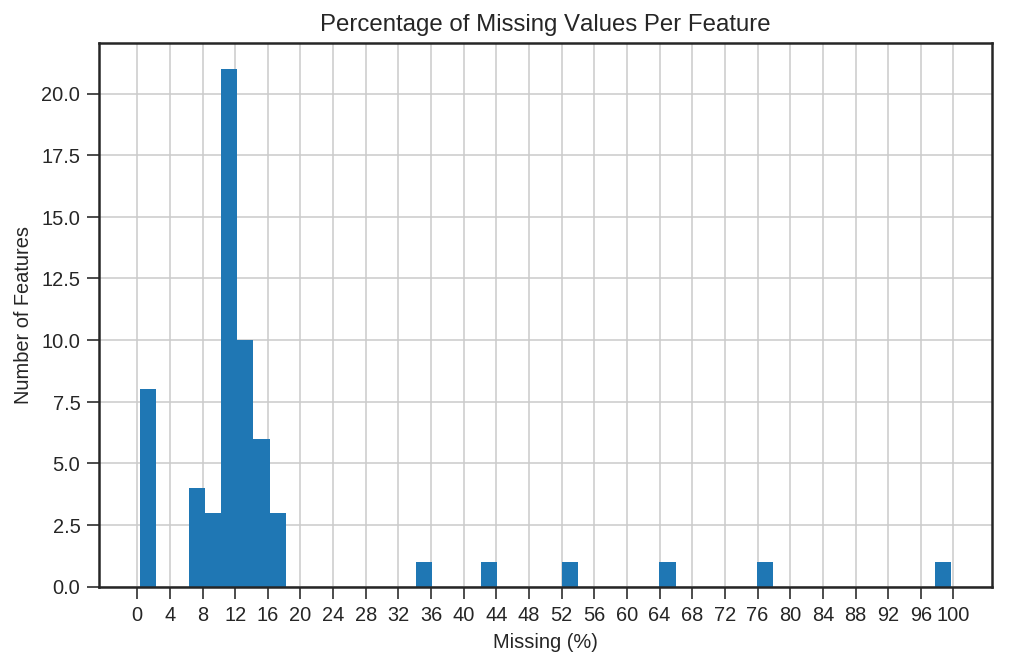

In [10]:
## Investigate patterns in the amount of missing data in each column.
## View Histogram of Missing Values per feature:

plt.figure(figsize=(8, 5))
plt.hist(misVals_perFeature_perc, bins=50)
plt.title("Percentage of Missing Values Per Feature");
plt.ylabel("Number of Features");
plt.xlabel("Missing (%)");
plt.xticks(np.arange(0, 101, step=4))
plt.grid()

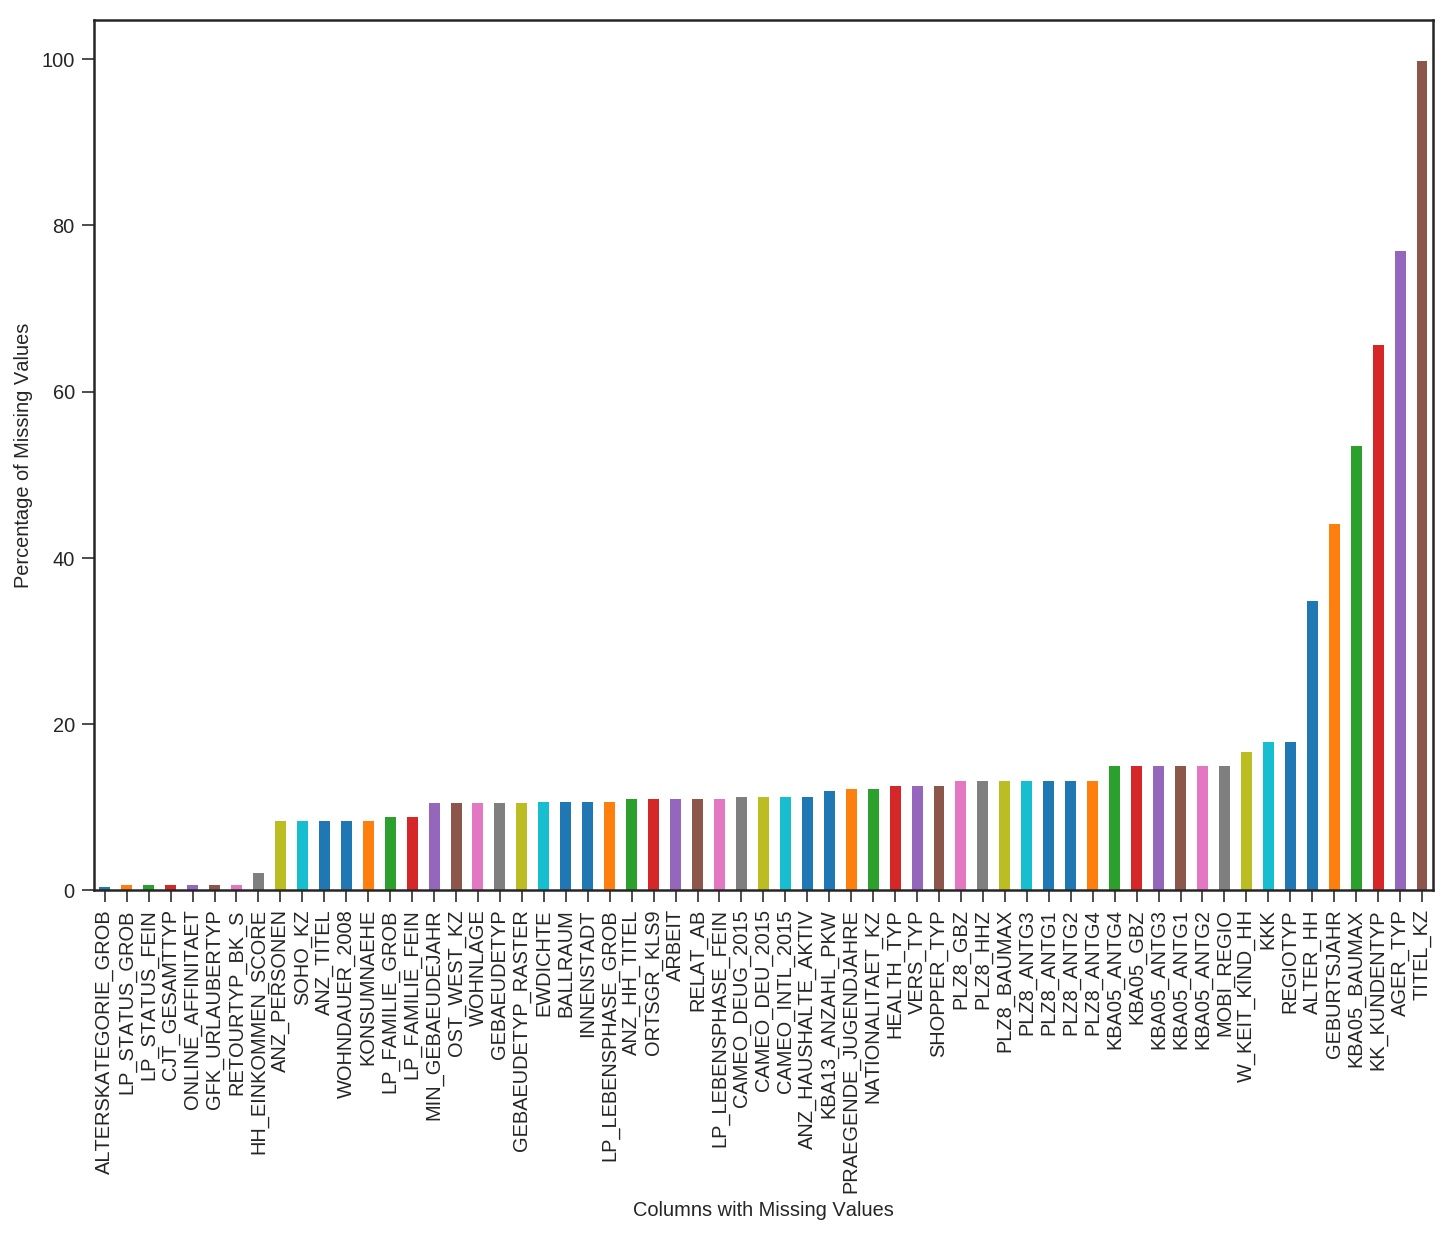

Total 61 columns with at least 1 missing value.


In [11]:
## Investigate patterns in the amount of missing data in each column.
## Show Missing Values in Ascending order:

misVals_perFeature_perc_asc = misVals_perFeature_perc.sort_values(ascending=True)

misVals_perFeature_perc_asc.plot.bar(figsize=(12, 8))
plt.xlabel('Columns with Missing Values')
plt.ylabel('Percentage of Missing Values')

plt.show()
print("Total {} columns with at least 1 missing value.".format(len(misVals_perFeature_perc_asc)))

As both the histogram and bar chart illustrated above, most features, i.e. columns, have less than 20% of missing values. Only 6 out of 85 columns have more than 20% missing values. Hence, we set the mart at 20% missing value rate per column to differentiate the outliers.

**Columns with more than 20% missing values are considered Outliers.**

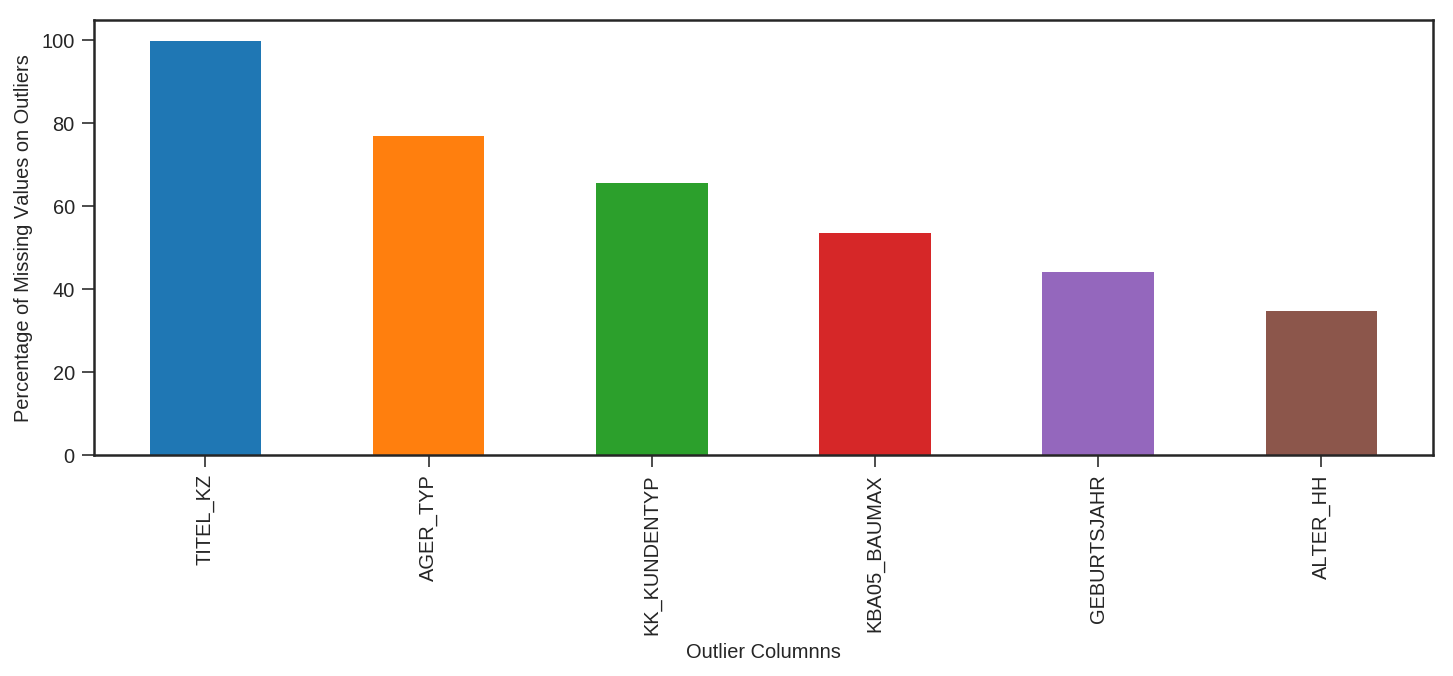

Total 6 Outlier Features, Missing Values > 20% :
 ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'].


In [12]:
## Identify the Outlier Columns as those with the missing value percentage per column > 20 % 

## Set the Outlier mark at 20%
mgnOutlier_perc = 20

serColOutliers = misVals_perFeature_perc[misVals_perFeature_perc > mgnOutlier_perc]
## return a Series, no DataFrame.

## Collect Outlier Column Names:
colOutliers = [ i for i in serColOutliers.index]

## Visualize all Outliers
serColOutliers.plot.bar(figsize=(12, 4))

plt.xlabel('Outlier Columnns')
plt.ylabel('Percentage of Missing Values on Outliers')

plt.show()

print("Total {} Outlier Features, Missing Values > {}% :\n {}.".format(len(colOutliers), mgnOutlier_perc, colOutliers))

In [13]:
## Remove Outlier Features:

print("Dataframe dimension before dropping outliers: {}".format(azdias.shape))  ## (891221, 85)

## Remove the outlier columns from the dataset:
azdias = azdias.drop(columns = colOutliers)

## Verify - assessment (To-Do)
## Six outlier columns, i.e. > 20% missing values, have been dropped. azdias.shape[1] == 79.

## Update the number of Rows and Columns - After Column NaNs filled:
numEntities, numAttrs = azdias.shape

print("Verify Dataframe dim after dropping outliers: {}".format(azdias.shape))  ## (891221, 85)
## azdias.shape  ## (891221, 79)
numEntities, numAttrs

Dataframe dimension before dropping outliers: (891221, 85)
Verify Dataframe dim after dropping outliers: (891221, 79)


(891221, 79)

In [14]:
## Update the column list of the dataframe, ColNames_l, to reflect the Outlier feature removal: 
colNames_l = getColNames(azdias)    ## 79

## Get a list of all Columns with Missing value:
colMisVals = [ i for i in misVals_perFeature.index]  ## len(colMisVals) still 61

### <a id='step_1_1_2d'></a> Discussion 1.1.2: Assess Missing Data in Each Column
>The majority of the features (columns) have less than 20% of missing data. We define the margin of "more than 20% missing values per column" for Outliers. In total of 85 original features, 61 features contains at least one missing values. Among those, six columns are outliers. These 6 columns are listed as follows,

>'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ'

### <a id='step_1_1_3'></a> Step 1.1.3: Assess Missing Data in Each Row

Now, we perform a similar assessment for the rows of the dataset.

How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values.

Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.

- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.

- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

### Histogram : Distribution of Rows with Number of Missing Features

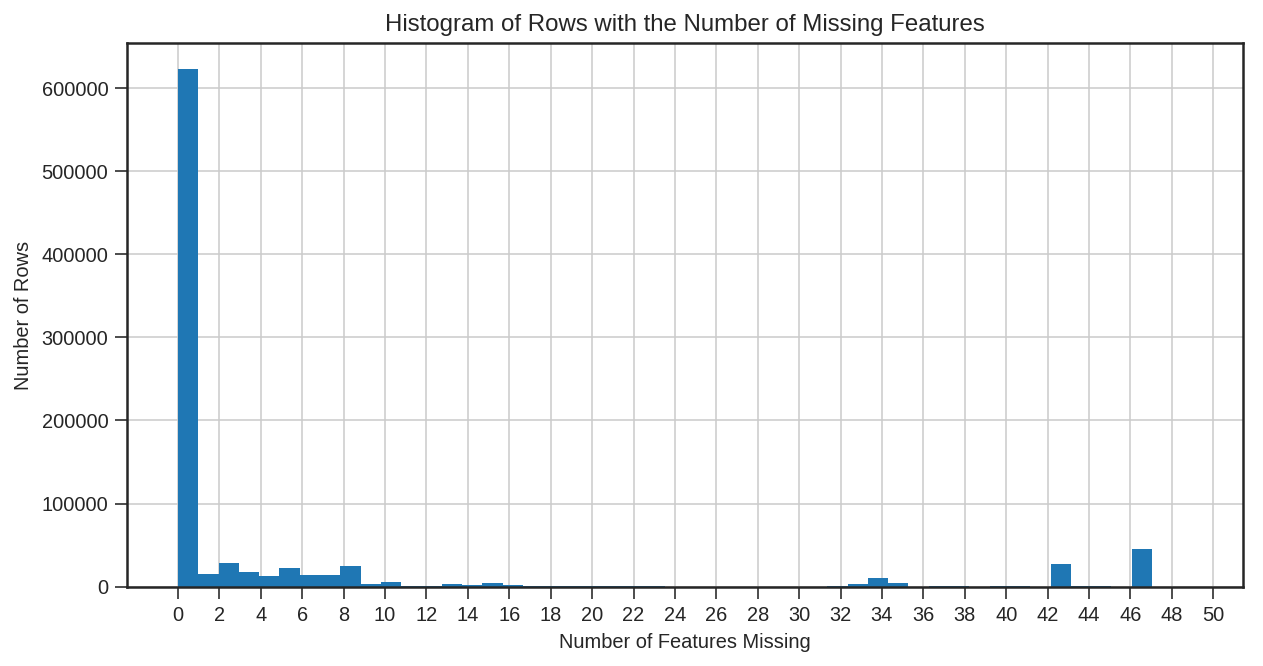

In [15]:
## How much data is missing in each row of the dataset?

## misVals_perRow = azdias.isna().sum(axis=1)
misAttrs_Row = azdias.isna().sum(axis=1)
#XX# misVals_perRow   ## Beaware: Too long...Don't print!!

plt.figure(figsize = (10, 5))
plt.hist(misAttrs_Row, bins=50)
plt.title("Histogram of Rows with the Number of Missing Features");
plt.ylabel("Number of Rows");
plt.xlabel("Number of Features Missing");
plt.xticks(np.arange(0, 51, step=2))
plt.grid()

As the above histogram illustrated, the majority of rows have less than 10 missing features. We can divide the data set into two parts. One with less than 2 missing features and the other with more than or equal to 2 features missing. 

In [16]:
## Write code to divide the data into two subsets based on "the number of missing values (features) in each row".

## Set Mark for two subsets - Rows with less than or equal to 2 missing features, Low; otherwise, High: 
mgnMisFeat = 2   ## Threshold - Number of missing Features (or Attributes, Column Values) in a row

azdias_LowMisAttrs_Row = azdias[misAttrs_Row <= mgnMisFeat].reset_index(drop=True)
azdias_HighMisAttrs_Row = azdias[misAttrs_Row > mgnMisFeat].reset_index(drop=True)

In [17]:
## Columns with zero missing values
solidCols = [ i for i in colNames_l if i not in misVals_perFeature.index]
print(len(solidCols))  ## 24; ## Verified: 61 + 24 = 85 (total # of features)
solidCols

24


['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

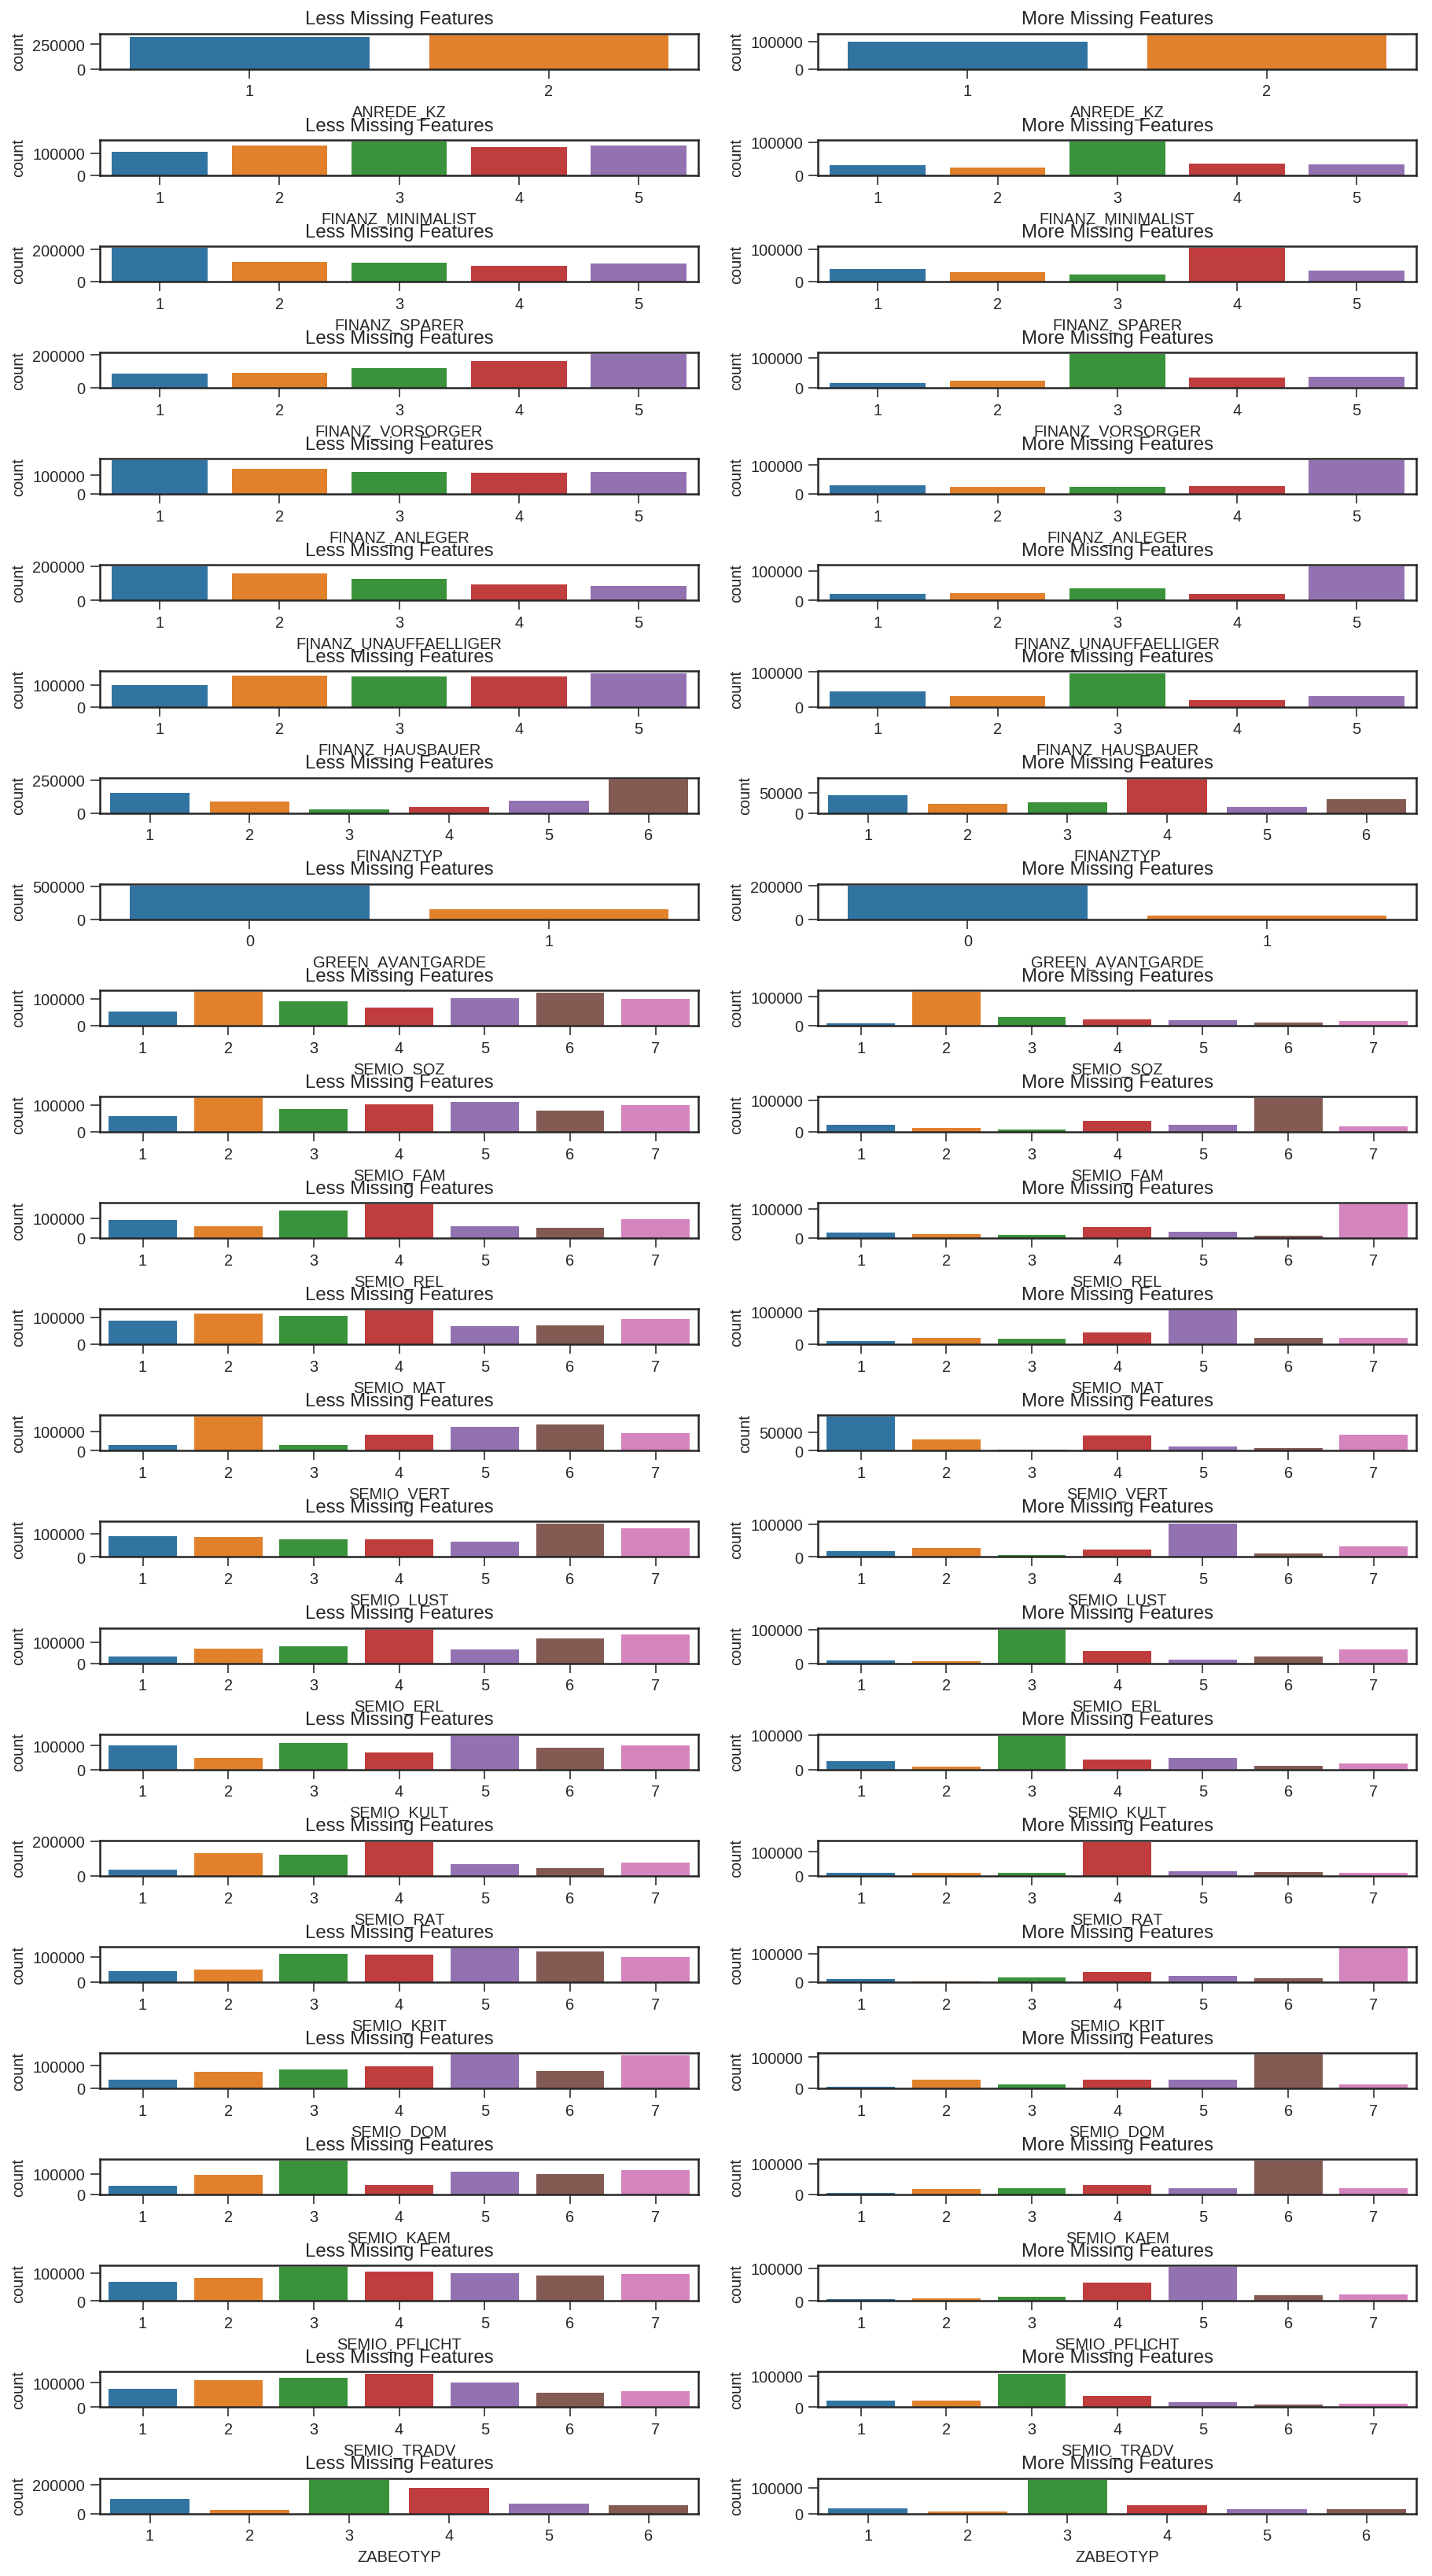

In [18]:
## Compare the distribution of values for at least five columns where there are no or few missing values, between the
## two subsets.

def drawSubplots(cols, numRow, numCol):

  ## fig, axs = plt.subplots(numRow, numCol, figsize=(15, 19), facecolor='w', edgecolor='k')
  fig, axs = plt.subplots(numRow, numCol, figsize=(15, 29), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace= 2, wspace= .2)
  axs = axs.ravel()

  for i in range(numRow):
    sns.countplot(azdias_LowMisAttrs_Row[cols[i]], ax=axs[i*2])
    axs[i*2].set_title('Less Missing Features')

    sns.countplot(azdias_HighMisAttrs_Row[cols[i]], ax=axs[i*2+1])
    axs[i*2+1].set_title('More Missing Features')

numSolidCols = len(solidCols)
numCol = 2
## numRow = numSolidCols >> 1
numRow = numSolidCols
if numSolidCols > numRow * numCol:
  numRow += 1

drawSubplots(solidCols, numRow, numCol)

### <a id='step_1_1_3d'></a> Discussion 1.1.3: Assess Missing Data in Each Row

The "histogram of missing features in rows" showed that most rows have 9 or less missing features. The majority of rows with missing features have 1 missing feature after we dropped the outlier columns. Hence, I set a mark at 2 (missing features in a row). Rows with more than 2 missing features are classified to the High subset.  

The countplots for 24 columns with no or few missing values suggested that the data with many missing values does not look very different than those with few or no missing values. Therefore, I assume, excluding those rows with many missing features from the analysis won't cause negative impact on the final outcome.

For the rest of missing values I have **two options**:

**A) Dropping all the missing features.** The problem with this method is that we filter out almost 80% of the data and the missing values are spread across all rows and columns. We would end up with about 92000 rows which may not be sufficient to represent the original data size.

**B) Filling missing features with the mode of each column.** This way we won't exclude too many data. We would end up with 459406 rows which is around 50% of the original data size. The problem with this method is that we are not sure whether using mode is the best way to impute the missing values.

**I'll go with option B so we can preserve as many records as possible.**

### <a id='step_1_2'></a>  Step 1.2: Select and Re-Encode Features
Since the unsupervised learning technique, KMeans, only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. After checking for missing data let's take care categorical features, i.e. those not represented by numeric values.

The third column in the feature summary (`feat_info`) recorded the types of measurement.
- Numeric and interval features remain. No change required.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will
- perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each.
- Then, in the last part, you will create a new data frame with only the selected and engineered columns.

In [19]:
## Number of Features in Each Feature Data Type
print("Number of Features in Each Feature Data Type: {}".format(
                                feat_info.groupby(['type'])['attribute'].count()))

Number of Features in Each Feature Data Type: type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64


#### <a id='step_1_2_1'></a> Step 1.2.1: Re-Encode Categorical Features

For categorical features, I encoded the levels as dummy variables. Depending on the number of categories, I performed one of the following conversion:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
## Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

## Collect a List of all Attributes in feat_info:
colAttrs_feat_info_l = [i for i in feat_info.attribute ]

## Retrieve categorical attributes:
catAttrs = feat_info[ feat_info["type"] == "categorical" ]

## Collect a list of Categorical attributes in feat_info: 
catAttrs_l = [i for i in catAttrs.attribute]
catAttrs_l

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [21]:
colNames_azdias_LowMisAttrs_Row = getColNames(azdias_LowMisAttrs_Row)
colNames_feat_list = [i for i in feat_info.attribute ]  ## feat_info["attribute"]
            
print("\nazdias_LowMisAttrs_Row Column Names: {}".format( colNames_azdias_LowMisAttrs_Row ))
print("\nLength of azdias_LowMisAttrs_Row Column names: {}".format(
                                                          len(colNames_azdias_LowMisAttrs_Row)))

print("\nfeat_info Attribute Names: {}".format( colNames_feat_list ))
print("\nLength of feat_info attributes: {}".format( len(colNames_feat_list) ) )


azdias_LowMisAttrs_Row Column Names: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA0

In [22]:
## Extract categorical columns with their data types and number of categories
for col in azdias_LowMisAttrs_Row.columns:

  ## Exclude Outlier Features:
  if col in colOutliers:
    continue

  #X# if feat_info.loc[col].type == 'categorical':
  if col in catAttrs_l:
    print(col, len(azdias_LowMisAttrs_Row[col].unique()), azdias_LowMisAttrs_Row[col].dtype)

ANREDE_KZ 2 int64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 int64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 int64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 object
CAMEO_DEU_2015 44 object


In [23]:
## Separate multi_level vs. binary categorical variables:
## Extract categorical columns with more than 2 categories

mLvl_CatAttrs_l = []
bLvl_CatAttrs_l = []

for feature in list(catAttrs['attribute']):

  if feature in colOutliers:
    continue

  if len( azdias[feature].value_counts() ) > 2:
    mLvl_CatAttrs_l.append(feature)

  else:
    bLvl_CatAttrs_l.append(feature)

print("Total: {} Multi-level Categorical attributes;\n{}\n".format(len(mLvl_CatAttrs_l),
                                                                   mLvl_CatAttrs_l))

print("Total: {} Binary Categorical attributes;\n{}\n".format(len(bLvl_CatAttrs_l),
                                                              bLvl_CatAttrs_l)) 

Total: 13 Multi-level Categorical attributes;
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Total: 5 Binary Categorical attributes;
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']



In [24]:
## Remove categorical columns with more than 2 categories

print("azdias_LowMisAttrs_Row Dim - Before: {}".format(azdias_LowMisAttrs_Row.shape))

for col in mLvl_CatAttrs_l:
  azdias_LowMisAttrs_Row.drop(col, axis=1, inplace=True)

print("azdias_LowMisAttrs_Row Dim - After: {}".format(azdias_LowMisAttrs_Row.shape))

azdias_LowMisAttrs_Row Dim - Before: (666873, 79)
azdias_LowMisAttrs_Row Dim - After: (666873, 66)


In [25]:
## Re-encoding all the binary categorical variable(s)
azdias_LowMisAttrs_dummies = pd.get_dummies(data = azdias_LowMisAttrs_Row,
                                            columns = bLvl_CatAttrs_l,
                                            prefix = bLvl_CatAttrs_l)
azdias_LowMisAttrs_dummies.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1.0,1,5,2,5,4,5,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,1,0,0,1,0,1,0,1
1,3.0,1,4,1,2,3,5,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,1,1,0,1,0,0,1
2,3.0,4,3,4,1,3,2,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,1,0,1,0,0,1,0,1
3,1.0,3,1,5,2,2,5,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,1,0,0,1,0,1
4,2.0,1,5,1,5,4,3,2.0,2.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,5.0,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1,1,0,1,0,1,0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features
>Among 18 categorical features, I dropped 13 Multi-level ones and re-encoded 5 Binary features to numeric values using Pandas get_dummies() method. The total number of features reduced from 79 to 66.

### <a id='step_1_2_2'></a>  Step 1.2.2: Engineer Mixed-Type Features
There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. Along the process three mixed-type features were addressed.

Among them, the OST_WEST_KZ feature was encoded without user intervension. This feature was engineered (encoded) into OST_WEST_KZ_O and OST_WEST_KZ_W.

The other two features are more complicate. They demanded further attention:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [26]:
## Find the column names for mixed type columns

mixedAttrs = feat_info[ feat_info["type"] == "mixed" ]
mixedAttrs_l = [i for i in mixedAttrs.attribute]
mixedAttrs_l

colNames_azdias_LowMixedMisAttrs_Row_l = []
for col in colNames_azdias_LowMisAttrs_Row:

  if col in colOutliers:
    continue

  if col in mixedAttrs_l:
    colNames_azdias_LowMixedMisAttrs_Row_l.append(col)
        
colNames_azdias_LowMixedMisAttrs_Row_l

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [27]:
## Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
## Check azdias_LowMisAttrs_dummies to see if there may be any categorical features left -

for col in azdias_LowMisAttrs_dummies.columns:

  ## Exclude Outlier Features:
  if col in colOutliers:
    continue

  ## Verify to see if any 'categorical' featuer exist:
  if col in catAttrs_l:
    print(col, len(azdias_LowMisAttrs_dummies[col].unique()), azdias_LowMisAttrs_dummies[col].dtype)

In [28]:
## Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

decade_l = []
azdias_LowMisAttrs_dummies_l = list(azdias_LowMisAttrs_dummies['PRAEGENDE_JUGENDJAHRE'])

for i in range ( len(azdias_LowMisAttrs_dummies_l) ):

  dec = azdias_LowMisAttrs_dummies_l[i]

  if dec in [1,2]:
    decade_l.append(1)
  elif dec in [3,4]:
    decade_l.append(2)
  elif dec in [5,6,7]:
    decade_l.append(3)
  elif dec in [8,9]:
    decade_l.append(4)
  elif dec in [10,11,12,13]:
    decade_l.append(5)
  elif dec in [14,15]:
    decade_l.append(6)
  else:
    decade_l.append(np.nan)

In [29]:
movement_l =[]

for i in range ( len(azdias_LowMisAttrs_dummies_l) ):

    mov = azdias_LowMisAttrs_dummies_l[i]

    if mov in [2,4,6,7,9,11,13,15]:
        movement_l.append(1)
    elif mov in [1,3,5,8,10,12,14]:
        movement_l.append(2)
    else:
        movement_l.append(np.nan)

In [30]:
## Adding two new features and dropping 'PRAEGENDE_JUGENDJAHRE'

azdias_LowMisAttrs_dummies["PRAEGENDE_JUGENDJAHRE_DECADE"] = decade_l
azdias_LowMisAttrs_dummies["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = movement_l

azdias_LowMisAttrs_dummies = azdias_LowMisAttrs_dummies.drop("PRAEGENDE_JUGENDJAHRE", axis=1)

In [31]:
## Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth_l = []
azdias_LowMisAttrs_dummies_cameo_l = list(azdias_LowMisAttrs_dummies['CAMEO_INTL_2015'])

for i in range (len(azdias_LowMisAttrs_dummies_cameo_l)):

  wealth = azdias_LowMisAttrs_dummies_cameo_l[i]

  if(type(wealth) != float):
    wealth_l.append(int(wealth[0]))
  else:
    wealth_l.append(np.nan)

In [32]:
life_stage_l =[]

for i in range (len(azdias_LowMisAttrs_dummies_cameo_l)):

    life_stage = azdias_LowMisAttrs_dummies_cameo_l[i]

    if(type(life_stage) != float):
        life_stage_l.append(int(life_stage[1]))
    else:
        life_stage_l.append(np.nan)

In [33]:
## Adding the two new features and dropping "CAMEO_INTL_2015"

azdias_LowMisAttrs_dummies["CAMEO_INTL_2015_WEALTH"] = wealth_l
azdias_LowMisAttrs_dummies["CAMEO_INTL_2015_LIFE_STAGE"] = life_stage_l

azdias_LowMisAttrs_dummies = azdias_LowMisAttrs_dummies.drop("CAMEO_INTL_2015", axis=1)

In [34]:
azdias_LowMisAttrs_dummies.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.0,1,5,2,5,4,5,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,1,0,0,1,0,1,0,1,6.0,2.0,5,1
1,3.0,1,4,1,2,3,5,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,1,1,0,1,0,0,1,6.0,1.0,2,4
2,3.0,4,3,4,1,3,2,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,1,0,1,0,0,1,0,1,4.0,2.0,4,3
3,1.0,3,1,5,2,2,5,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1,0,1,0,0,1,0,1,2.0,2.0,5,4
4,2.0,1,5,1,5,4,3,2.0,2.0,1.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,5.0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1,1,0,1,0,1,0,0,1,5.0,2.0,2,2


#### Discussion 1.2.2: Engineer Mixed-Type Features
Two mixed-type features, 'PRAEGENDE_JUGENDJAHRE' and "CAMEO_INTL_2015", were inspected.
>- "PRAEGENDE_JUGENDJAHRE_MOVEMENT" : 1 for AVANTGARDE and 2 for MAINSTREAM
>- "PRAEGENDE_JUGENDJAHRE_DECADE" : 1 for 1940s, 2 for 1950s, 3 for 1960s, 4 for 1970s, 5 for 1980s and 6 for 1990s 
>- "CAMEO_INTL_2015_WEALTH" : 1 for WEALTHY, 2 for PROSPEROUS, 3 for COMFORTABLE, 4 for LESS AFFLUENT and 5 for POORER
>- "CAMEO_INTL_2015_LIFE_STAGE" : 1 for Pre-Family Couples & Singles, 2 for Young Couples With Children, 3 for Families With School Age Children, 4 for Older Families &  Mature Couples and 5 for Elders In Retirement

In [35]:
## Again, check azdias_LowMisAttrs_dummies to see if there may be any categorical features left -
for col in azdias_LowMisAttrs_dummies.columns:

  ## Exclude Outlier Features:
  if col in colOutliers:
    continue

  ## Verify to see if any 'categorical' featuer exist:
  if col in catAttrs_l:
    print(col, len(azdias_LowMisAttrs_dummies[col].unique()), azdias_LowMisAttrs_dummies[col].dtype)

### <a id='step_1_2_3'></a>  Step 1.2.3: Complete Feature Selection

A quick checking on the Demographics data frame showed that it only contained the features that I wanted to keep and the dataframe consisted of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

The original columns, 'PRAEGENDE_JUGENDJAHRE' and "CAMEO_INTL_2015", from which the engineered features were derived have all been dropped from the final dataset. Their values won't interfere with the analysis on the project.

The 'OST_WEST_KZ' feature consisted of "W" and "O", encoded as "W": 0 and "O": 1 accordingly.

And, the datafrome was only made from **the subset with few or no missing values**.

### <a id='step_1_3'></a>  Step 1.3: Create a Cleaning Function

Here I created a function to streamline this workflow, namely `data cleaning`, `feature selection`, `encoding` and `re-engineering`. Going forward we can apply this function on other customer demographics data and look for reducing the amount of time investing on similar process.

With this systematic approach, we can just run this function on the DataFrame and retrieve a trimmed dataset in a single step.

In [36]:
def clean_data(df):
  """
  Perform feature trimming, re-encoding, and engineering for demographics
  data
    
  INPUT: Demographics DataFrame
  OUTPUT: Trimmed and cleaned demographics DataFrame
  """
    
  ## Put in code here to execute all main cleaning steps:
  ## Load in the feature summary file.
  feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

  ## convert missing value codes into NaNs, ...
  values = ['-1','0','1','2','3','4','5','6','7','8','9']

  numRows, numCols = df.shape

  for column in range(numCols):

    missing_values = feat_info.iloc[column][3]
    missing_values = missing_values.strip('[')
    missing_values = missing_values.strip(']')
    missing_values = missing_values.split(sep=',')
    
    for i in range(len(missing_values)):
      if missing_values[i] in values:
        missing_values[i] = int(missing_values[i])

    if(missing_values != ['']):
        df = df.replace({feat_info.iloc[column][0]: missing_values}, np.nan)

  ## Perform an assessment of how much missing data there is in each column of the dataset.
  missing_values_per_feature = df.isnull().sum()
  missing_values_per_feature = missing_values_per_feature / numRows
  missing_values_per_feature = missing_values_per_feature.sort_values() * 100

  ## Remove the outlier columns from the dataset. (You'll perform other data
  ## engineering tasks such as re-encoding and imputation later.)
  outlier_column = []
  mgnOutlier_perc = 20
  
  for column in range(numCols):

    current_column = df.columns.values[column]
    percent_missing_current_column = missing_values_per_feature[column]

    if percent_missing_current_column > mgnOutlier_perc:
      outlier_column.append(current_column)

  ## remove selected columns and rows, ...
  mgnMisFeat = 2 
  df = df.drop(columns = outlier_column)
  df_low = df[df.isnull().sum(axis=1) < mgnMisFeat]


  ## Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
  ## select, re-encode, and engineer column values:

  #### Collect a List of all Attributes in feat_info:
  ## colAttrs_feat_info_l = [i for i in feat_info.attribute ]

  categorical_variables = feat_info[ feat_info['type'] == 'categorical' ]
  ## Collect a list of Categorical attributes in feat_info: 
  categorical_variables_l = [i for i in categorical_variables.attribute]

  multi_level = []
  binary = []

  ## for feature in list(categorical_variables['attribute']):
  for feature in categorical_variables_l:
    
    if feature in outlier_column:
      continue
    
    if len(df[feature].value_counts()) > 2:
      multi_level.append(feature)
    
    else:
      binary.append(feature)

  ## Dropping the multi level categorical variables
  for column in multi_level:
    df_low.drop(column, axis=1, inplace=True)
        
  ## Re-encode categorical variable(s) to be kept in the analysis.
  df_low_dummies = pd.get_dummies(data=df_low, columns=binary, prefix=binary)
  df_low_dummies.head()


  ## Find the column names for mixed type columns

  mixedAttrs = feat_info[ feat_info["type"] == "mixed" ]
  mixedAttrs_l = [i for i in mixedAttrs.attribute]

  mixed_cat_l = []
  for col in df_low:

    if col in outlier_column:
      continue

    if col in mixedAttrs_l:
      mixed_cat_l.append(col)


  ## Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
  movement_l = []
  value1 = list(df_low_dummies['PRAEGENDE_JUGENDJAHRE'])
  for i in range ( len(value1) ):
    mov = value1[i]
    if mov in [1,2]:
      movement_l.append(1)
    elif mov in [3,4]:
      movement_l.append(2)
    elif mov in [5,6,7]:
      movement_l.append(3)
    elif mov in [8,9]:
      movement_l.append(4)
    elif mov in [10,11,12,13]:
      movement_l.append(5)
    elif mov in [14,15]:
      movement_l.append(6)
    else:
      movement_l.append(np.nan)


  decade_l =[]
  for i in range ( len(value1) ):
    dec = value1[i]
    if dec in [2,4,6,7,9,11,13,15]:
      decade_l.append(0)
    elif dec in [1,3,5,8,10,12,14]:
      decade_l.append(1)
    else:
      decade_l.append(np.nan)

  df_low_dummies["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = movement_l
  df_low_dummies["PRAEGENDE_JUGENDJAHRE_DECADE"] = decade_l
  df_low_dummies = df_low_dummies.drop("PRAEGENDE_JUGENDJAHRE", axis=1)


  ## Investigate "CAMEO_INTL_2015" and engineer two new variables.
  try:
    wealth_l = []
    value2 = list(df_low_dummies['CAMEO_INTL_2015'])
    
    ## for i in range ( len( list(df_low_dummies['CAMEO_INTL_2015']) ) ):
    for i in range ( len(value2) ):
      wealth = value2[i]
      if( type(wealth) != float ):
        wealth_l.append(int(wealth[0]))
      else:
        wealth_l.append(np.nan)


    life_stage_l =[]
    ## for i in range ( len( list(df_low_dummies['CAMEO_INTL_2015']) ) ):
    for i in range ( len(value2) ):
      life_stage = value2[i]
      if( type(life_stage) != float ):
        life_stage_l.append(int(life_stage[1]))
      else:
        life_stage_l.append(np.nan)

    ## df_low_dummies["CAMEO_INTL_2015_WEALTH"] = wealth_l
    ## df_low_dummies["CAMEO_INTL_2015_LIFE_STAGE"] = life_stage_l

    numRows, numCols = df_low_dummies.shape
    df_low_dummies.insert(numCols, "CAMEO_INTL_2015_WEALTH", wealth_l, True)
    df_low_dummies.insert(numCols+1, "CAMEO_INTL_2015_LIFE_STAGE", life_stage_l, True)
    if "CAMEO_INTL_2015" in df_low_dummies:
        df_low_dummies.drop("CAMEO_INTL_2015", axis=1, inplace=True)

  except KeyError as ek:
    print(ek)
  

  # Return the cleaned dataframe.
  return df_low_dummies

## <a id='step_2'></a> Step 2: Feature Transformation

### <a id='step_2_1'></a>  Step 2.1: Apply Feature Scaling

Since sklearn requires no missing value in a data set we need to take care of them for its estimators to work properly. Also, to avoid the differences in feature scales influence the principal component vectors we should perform feature scaling on features before applying dimensionality reduction techniques to the data. 

Hence, let's first explore and clean the dataset of all NaN values in the data set. And then, apply the scaler to the data.



In [37]:
## Top-15 Percentages of NaNs per column
showAttrsNaNPCTL(azdias)[:15]

KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
MOBI_REGIO        14.959701
KBA05_ANTG4       14.959701
KBA05_ANTG3       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG1       14.959701
KBA05_GBZ         14.959701
PLZ8_ANTG2        13.073637
PLZ8_ANTG1        13.073637
PLZ8_ANTG3        13.073637
PLZ8_ANTG4        13.073637
PLZ8_BAUMAX       13.073637
PLZ8_HHZ          13.073637
dtype: float64

In [38]:
## Imputing missing values with the mode
azdias_LowMisAttrs_dummies[list(azdias_LowMisAttrs_dummies.columns)]= azdias_LowMisAttrs_dummies[ \
     list(azdias_LowMisAttrs_dummies.columns)].fillna(azdias_LowMisAttrs_dummies.mode().iloc[0])

imp = Imputer(missing_values= np.nan, strategy='mean', axis=0)

In [39]:
## Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_LowMisAttrs_dummies[list(azdias_LowMisAttrs_dummies.columns)] = scaler.fit_transform( \
                          azdias_LowMisAttrs_dummies[list(azdias_LowMisAttrs_dummies.columns)])

In [40]:
azdias_LowMisAttrs_dummies.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.742284,-1.518333,1.584388,-1.052653,1.521225,1.046959,1.332026,1.044315,0.378678,0.273136,-1.660398,0.395804,-0.042183,0.061639,-0.425444,-1.728223,-1.100067,-1.418446,-0.586114,1.293190,-0.283497,1.303245,-0.138097,1.525025,1.253450,0.171480,-0.060805,0.993364,-0.693303,0.543885,0.169909,-0.129522,-1.297205,-0.380187,-0.022966,-1.074121,-1.015943,-0.612507,2.678143,-1.635425,0.853627,-0.567852,1.710079,-0.800773,-0.771817,-1.390845,0.160308,-0.845880,1.030232,-0.250586,0.204231,0.394812,0.401152,-0.655164,1.434272,0.569685,-0.188225,-0.145239,0.670993,-0.974592,0.974592,0.546393,-0.546393,-10.839373,10.839373,-0.942138,0.942138,-0.526576,0.526576,1.143731,0.546393,1.166730,-1.260429
1,0.193020,-1.518333,0.905963,-1.773152,-0.538858,0.320062,1.332026,1.044315,-1.078953,-1.047132,-0.286015,-0.115732,-1.604381,-0.473979,-0.425444,-0.155407,-0.150178,0.775204,-0.586114,0.094837,1.428638,1.303245,1.439575,-0.591431,-0.426672,-0.707385,-0.060805,-0.306552,-0.693303,0.543885,0.104831,-0.129522,1.300290,-0.380187,-1.078730,-0.366048,1.399542,0.373493,-0.472277,-0.128130,-0.972294,0.015740,-0.258772,0.290323,-0.771817,0.008392,-0.481303,-1.395667,0.284852,0.773837,0.204231,-0.618732,-0.969671,-0.655164,0.401257,0.569685,-0.188225,-0.145239,-0.805024,-0.974592,0.974592,-1.830185,1.830185,0.092256,-0.092256,1.061416,-1.061416,-0.526576,0.526576,1.143731,-1.830185,-0.879379,0.748259
2,0.193020,0.681366,0.227538,0.388344,-1.225553,0.320062,-0.844853,1.044315,1.269453,1.329349,1.088368,0.907339,-0.042183,0.061639,-0.938700,1.417408,-0.150178,-0.321621,0.928190,-1.103516,-0.854208,-1.396392,-1.189878,-0.062317,-0.986713,1.929210,-0.060805,0.343406,-1.261829,0.543885,-0.350717,-0.129522,0.650916,-0.380187,-0.550848,-0.366048,2.204703,0.373493,-0.472277,-0.128130,-0.972294,0.599331,-1.735411,1.381418,0.270577,0.008392,1.443531,0.253695,-0.537739,-0.250586,1.291069,0.394812,0.401152,0.026653,-0.631759,-0.328905,0.817674,0.289488,1.409001,1.026070,-1.026070,0.546393,-0.546393,0.092256,-0.092256,-0.942138,0.942138,-0.526576,0.526576,-0.227754,0.546393,0.484694,0.078696
3,-1.742284,-0.051867,-1.129311,1.108842,-0.538858,-0.406835,1.332026,1.044315,-0.674056,-0.783078,-0.286015,-1.138803,-0.042183,1.668495,0.087812,-1.203951,-1.100067,-1.418446,0.423422,1.892367,-0.283497,-0.316537,-0.138097,1.525025,1.253450,-0.707385,-0.060805,0.343406,1.012275,0.543885,-0.220560,-0.129522,1.300290,-0.380187,1.560679,0.342025,0.594380,-0.612507,-0.472277,0.625518,0.853627,-1.151443,1.217866,0.290323,1.312970,0.708010,-1.122914,0.253695,2.031002,-0.250586,0.204231,-0.618732,0.401152,-0.655164,1.434272,1.468275,-1.194124,-1.014691,-0.067015,-0.974592,0.974592,0.546393,-0.546393,0.092256,-0.092256,-0.942138,0.942138,-0.526576,0.526576,-1.599239,0.546393,1.166730,0.748259
4,-0.774632,-1.518333,1.584388,-1.773152,1.521225,1.046959,-0.119227,-0.279180,-1.159933,-1.047132,0.401177,-1.138803,0.478549,0.597258,1.627580,-1.203951,0.799711,0.226792,0.423422,1.892367,1.428638,-0.316537,

### Discussion 2.1: Apply Feature Scaling
>During final inspection before wrapping up feature selection, I found 'OST_WEST_KZ' feature contained Object (String), "W" and "O". Applied an encoding rule, "W": 0 and "O": 1. 
>Before applying feature scaling , I replaced the missing values with the **mode values** of the corresponding columns.

### <a id='step_2_2'></a> Step 2.2: Perform Dimensionality Reduction
With the scaled data, we're ready to apply dimensionality reduction techniques. We have these options:

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To begin with, I did not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- I, then, Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I plotted the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on the diagram, I selected a value for the number of transformed features to retain for the clustering part of the project.
- The number of components to keep was then applied to re-fit the PCA instance and perform the decided-on transformation.

In [41]:
## Apply PCA to the demographics data set, azdias_LowMisAttrs_dummies.
pca = PCA()
azdias_Low_pca = pca.fit_transform(azdias_LowMisAttrs_dummies)

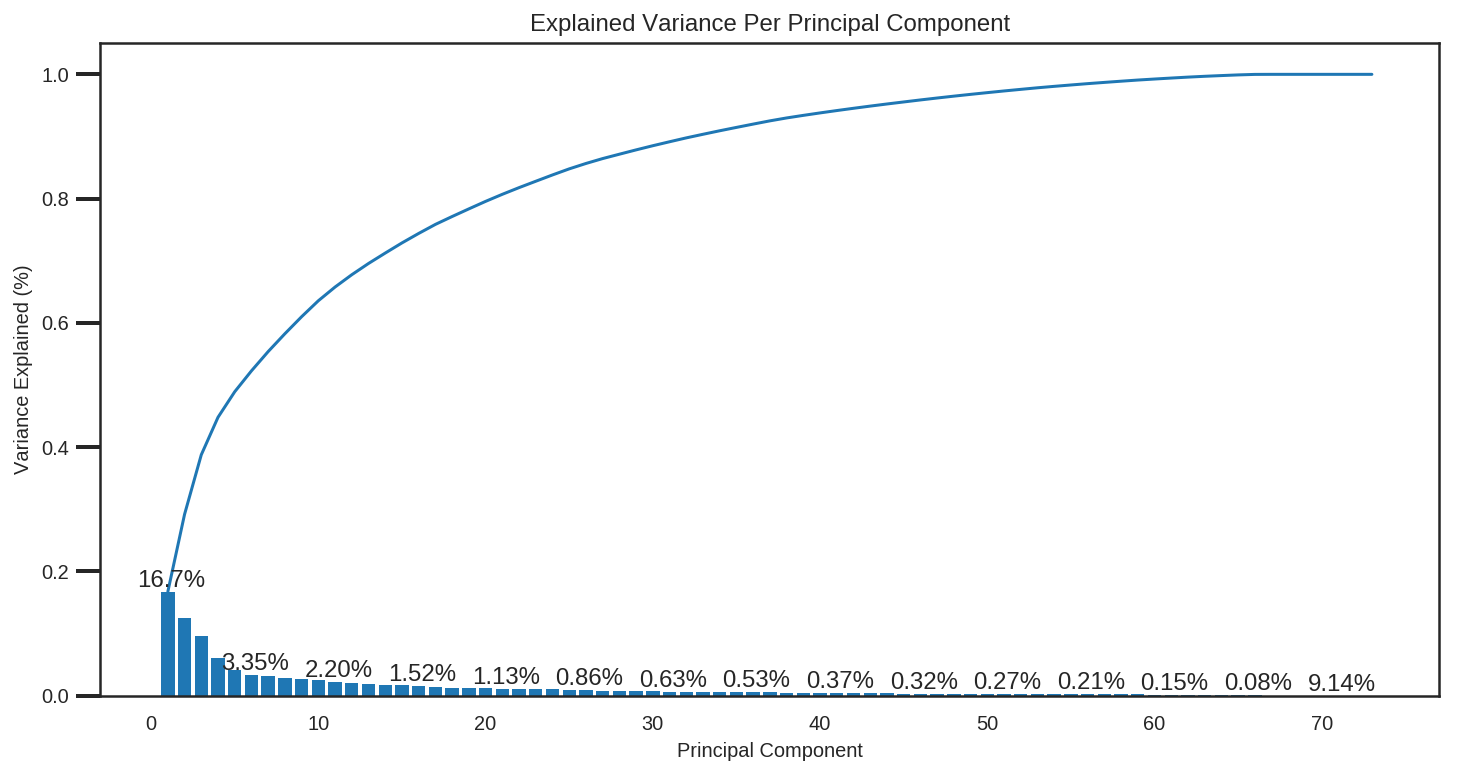

In [42]:
## Investigate the variance accounted for by each principal component.

def screen_plot(df):
  '''
  Creates a scree plot associated with the principal components 
    
  INPUT: pca - the result of instantian of PCA in scikit learn
            
  OUTPUT:
         None
    
  Credit:Udacity Nanodegree
  '''
    
  #### Do PCA - Problemetic!!
  ## df_pca = pca.fit_transform(df)
    
  # Get output vals
  num_components = len(pca.explained_variance_ratio_)
  vals = pca.explained_variance_ratio_
  ind = np.arange(1, num_components + 1)

  cumvals = np.cumsum(vals)
    
  # Plot Fig
  plt.figure(figsize=(12, 6))
  ax = plt.subplot(111)
    
  ax.bar(ind, vals)  ##
  ax.plot(ind, cumvals)

  for i in range(num_components):
    if(i%5==0):
      ax.annotate(r"%s%%" % (( str(vals[i]*100)[:4])),
                  (ind[i]+0.2, vals[i]),
                  va="bottom",
                  ha="center",
                  fontsize=12)

  ax.xaxis.set_tick_params(width=0)
  ax.yaxis.set_tick_params(width=2, length=12)

  ax.set_xlabel("Principal Component")
  ax.set_ylabel("Variance Explained (%)")
  plt.title('Explained Variance Per Principal Component')
    
# Call the function
screen_plot(azdias_Low_pca)


In [43]:
## Re-apply PCA to the data while selecting for number of components to retain.
numPCs = 30 if azdias_LowMisAttrs_dummies.shape[1] > 30 else azdias_LowMisAttrs_dummies.shape[1]
pca = PCA(n_components = numPCs)
azdias_Low_pca = pca.fit_transform(azdias_LowMisAttrs_dummies)

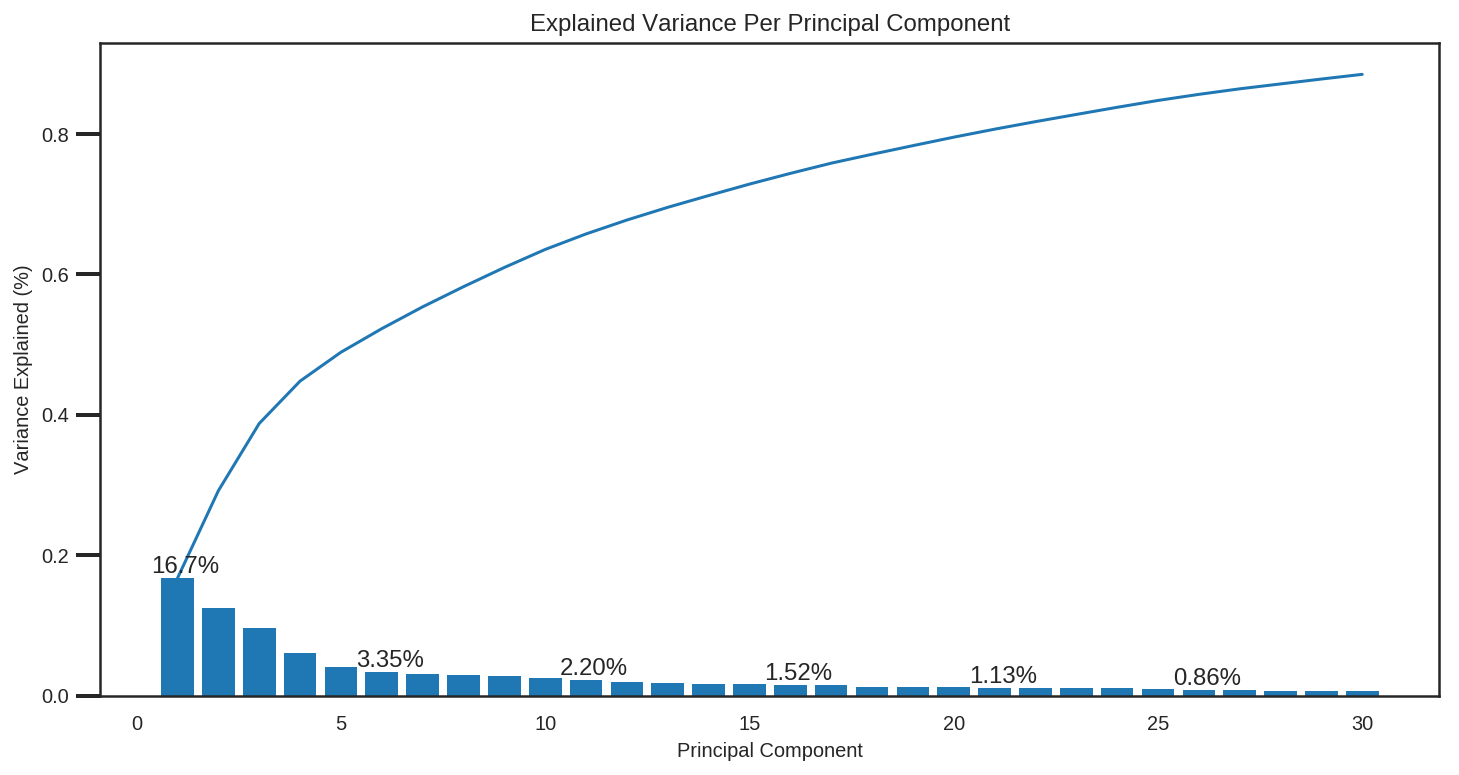

In [44]:
screen_plot(azdias_Low_pca)

### Discussion 2.2: Perform Dimensionality Reduction
>After applying PCA on my dataset, I noticed the variance per principal component after 30 principle components become negelable. Hence, I chose 30 to apply PCA again.

### <a id='step_2_3'></a>  Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I mapped each weight to their corresponding feature name, then sorted the features according to weight. The most interesting features for each principal components, then, are those at the beginning and end of the sorted list. 
- I investigated and interpreted feature associations from the first three principal components in this substep. To help facilitate this, I write a function so I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This came in handy in the next step of the project when I interpreted the tendencies of the discovered clusters.

In [45]:
def getFeatureWeights(nth_pc, pca, df):
  '''Function for calculating weights of the components'''

  colNames_l = list(df.columns)
  weights_l = list(pca.components_[nth_pc])

  df = pd.DataFrame( list(zip(colNames_l, weights_l)) )
  df.set_axis(['Feature', 'Weights'], axis=1, inplace=True)

  df = df.sort_values(by=['Weights'] , ascending=False)
  df.set_index('Feature', inplace=True)

  return df

In [46]:
## Map Weights for principal components to corresponding Features and print the linked values, sorted by weight.
## Principal Component 1
print(getFeatureWeights(1, pca, azdias_LowMisAttrs_dummies).head(4))
print(getFeatureWeights(1, pca, azdias_LowMisAttrs_dummies).tail(4))

                       Weights
Feature                       
ALTERSKATEGORIE_GROB  0.258114
SEMIO_ERL             0.250297
FINANZ_VORSORGER      0.225519
SEMIO_LUST            0.180181
                               Weights
Feature                               
FINANZ_SPARER                -0.235642
PRAEGENDE_JUGENDJAHRE_DECADE -0.237007
SEMIO_KULT                   -0.243112
SEMIO_REL                    -0.274878


#### Principal Component 1
>**PCA revealed the strongest positive feature weights are:** `ALTERSKATEGORIE_GROB`, `SEMIO_ER`L and `FINANZ_VORSORGER`, followed by `SEMIO_LUST`. It suggested the following areas have strong influence on analytics results. Information in these areas is critical and should be retain:
- Estimated age based on given name analysis,
- Personality typology wise, Event-oriented (ERL),
- Financial interest especially on "be-prepared" mindset, followed by
- Personality typology, sensual-minded .

>**The strongest negative feature weights are:** `SEMIO_REL`, `SEMIO_KULT`, followed by `PRAEGENDE_JUGENDJAHRE_DECADE` and `FINANZ_SPARER`.** Personality traits, Ages and Financial interests are dominant factors.

In [47]:
## Principal Component 2
print(getFeatureWeights(2, pca, azdias_LowMisAttrs_dummies).head(4))
print(getFeatureWeights(2, pca, azdias_LowMisAttrs_dummies).tail(4))

              Weights
Feature              
ANREDE_KZ_1  0.336667
SEMIO_VERT   0.316804
SEMIO_SOZ    0.230574
SEMIO_FAM    0.210211
              Weights
Feature              
SEMIO_KRIT  -0.233964
SEMIO_DOM   -0.279194
SEMIO_KAEM  -0.301604
ANREDE_KZ_2 -0.336667


#### Principal Component 2
>In the second principle component, **the strongest positive feature weights are:** `ANREDE_KZ_1` and `SEMIO_VERT`, followed by `SEMIO_SOZ` and `SEMIO_FAM`. Information on gender and personality typologies carry a lot of information.

>**The strongest negative feature weights are:** `ANREDE_KZ_2`, `SEMIO_KAEM`, `SEMIO_DOM` and `SEMIO_KRIT`. The negative feature weights suggest exactly the same areas as those on positive ones, genders and personality typoloties.

In [48]:
## Principal Component 3
print(getFeatureWeights(3, pca, azdias_LowMisAttrs_dummies).head(4))
print(getFeatureWeights(3, pca, azdias_LowMisAttrs_dummies).tail(4))

                      Weights
Feature                      
GREEN_AVANTGARDE_1   0.357257
EWDICHTE             0.240387
ORTSGR_KLS9          0.235379
LP_LEBENSPHASE_FEIN  0.134216
                                 Weights
Feature                                 
HH_EINKOMMEN_SCORE             -0.200482
WOHNLAGE                       -0.251026
PRAEGENDE_JUGENDJAHRE_MOVEMENT -0.357257
GREEN_AVANTGARDE_0             -0.357257


#### Principal Component 3
>PCA revealed that **the strongest positive feature weights are:** `GREEN_AVANTGARDE_1`, followed by `EWDICHTE` and `ORTSGR_KLS9`. Membership in environmental sustainability as part of youth, i.e. green avantgarde, carries important information. The density of households in an area (EWDICHTE) and the size of communities (ORTSGR_KLS9) carry critical info for our analyese. We should inlude them.

>**The strongest negative feature weights are:** `GREEN_AVANTGARDE_0` and `PRAEGENDE_JUGENDJAHRE_MOVEMENT`, followed by `WOHNLAGE` and `HH_EINKOMMEN_SCORE`. Green avantgarde, i.e. environmental sustainability, and dominating movement of person's youth are important data to our analyses. Neighborhood quality, i.e. rural flag and estimated household net income are also important influential data.

### Discussion 2.3: Interpret Principal Components
>Overall, the principle component analyses suggested which areas of features contain the most information. We should retain these features for our further analyses should the number of features be conserned as too higher. Three areas of features stood out as follows,
> - Ages, Genders, Personality traits, and Financial interests, such as spending patterns like money savers, minimalists, or prefer to posses home ownership are important data to keep.
> - Data in environmental sustainabiluty and dominating movement of person's youth are essential to the analyis. 
> - Last but not the least, Density of Households in an area, Size of Communities, Neighborhood Quality and Estimated Household net income are important data that we should keep. 

## <a id='step_3'></a> Step 3: Clustering

### <a id='step_3_1'></a> Step 3.1: Apply Clustering to General Population

Now the demographics data were assessed and cleaned. They're also scaled and transformed followed by PCA. It's time to see how the data clusters in the principal components space.

I applied k-means clustering to the dataset and used the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts and then observe how the average distance decreases with an increasing number of clusters. Since each additional cluster provides a smaller net benefit I leveraged this fact to select a final number of clusters in which to group the data.
- Due to  the large size of the data set, it took a long while for the algorithm to complete. In general, the more clusters to fit, the longer the algorithm will take. Hence, I first tested my code via a cluster count of 10. Yet, it should be noted that the test should run through, at least, 10 clusters to get the full picture. But the number of clusters should not go beyond 30.
- After choosing the final number of clusters to use, I re-fitted the K-Means instance to perform the clustering operation. I loaded the cluster assignments for the general demographics data in the final Step 3.3.

In [49]:
## Run k-means clustering on the data over a number of different cluster counts. Compute the average in-cluster distances.

def get_kmeans_score(data, center):

  seed = np.random.RandomState(42)
  kmeans = KMeans(n_clusters = center, random_state = seed)
  model = kmeans.fit(data)
  score = np.abs(model.score(data))

  return score


def fit_mods(data, centers):

  scores = []

  for i, center in enumerate(centers):

    print("No.{}'s Calculation".format(i + 1))
    scores.append(get_kmeans_score(data, center))

  return centers, scores

No.1's Calculation
No.2's Calculation
No.3's Calculation
No.4's Calculation
No.5's Calculation
No.6's Calculation
No.7's Calculation
No.8's Calculation
No.9's Calculation
No.10's Calculation


Text(0.5,1,'SSE vs. Number of Clusters')

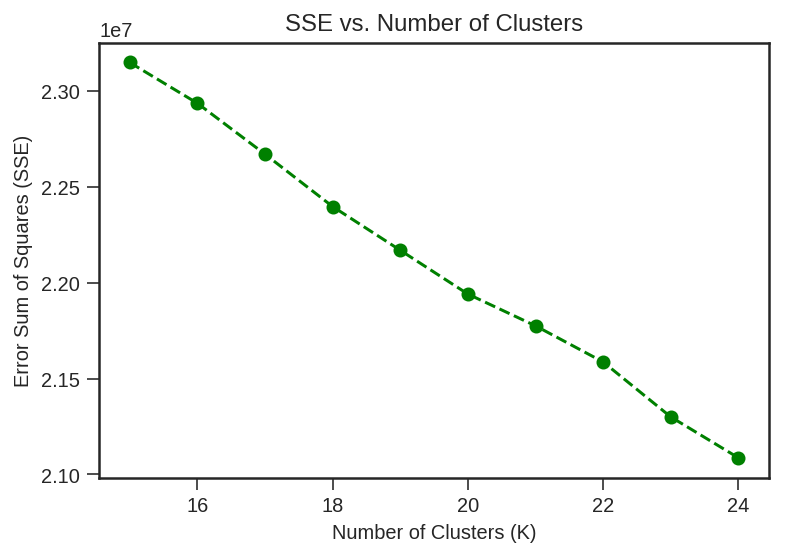

In [50]:
## Investigate the change in within-cluster distance across number of clusters.
## HINT: Use matplotlib's plot function to visualize this relationship.

centers, scores = fit_mods(azdias_Low_pca, list(range(15, 25)))
plt.plot(centers, scores, linestyle='--', marker='o', color='g');
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Error Sum of Squares (SSE)')
plt.title('SSE vs. Number of Clusters')

In [51]:
## Over a number of different cluster counts...

average=[]
numClusters = 18  ## 20

for i in range(numClusters):

  if(i % 2 == 0 and i != 0):

    ## run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i).fit(azdias_LowMisAttrs_dummies)

    ## Obtain a score related to the model fit
    score = np.abs(kmeans.score(azdias_LowMisAttrs_dummies))
    
    ## compute the average within-cluster distances.
    print("For n_clusters={}, average within-cluster distances = {}".format(i,score/azdias_LowMisAttrs_dummies.shape[0]))
    average.append(score / azdias_LowMisAttrs_dummies.shape[0])

For n_clusters=2, average within-cluster distances = 63.812688958081054
For n_clusters=4, average within-cluster distances = 56.42108384864964
For n_clusters=6, average within-cluster distances = 52.23293232241676
For n_clusters=8, average within-cluster distances = 49.29775471347159
For n_clusters=10, average within-cluster distances = 46.48615136751406
For n_clusters=12, average within-cluster distances = 44.93078848859272
For n_clusters=14, average within-cluster distances = 43.42515136363188
For n_clusters=16, average within-cluster distances = 43.195763013161205


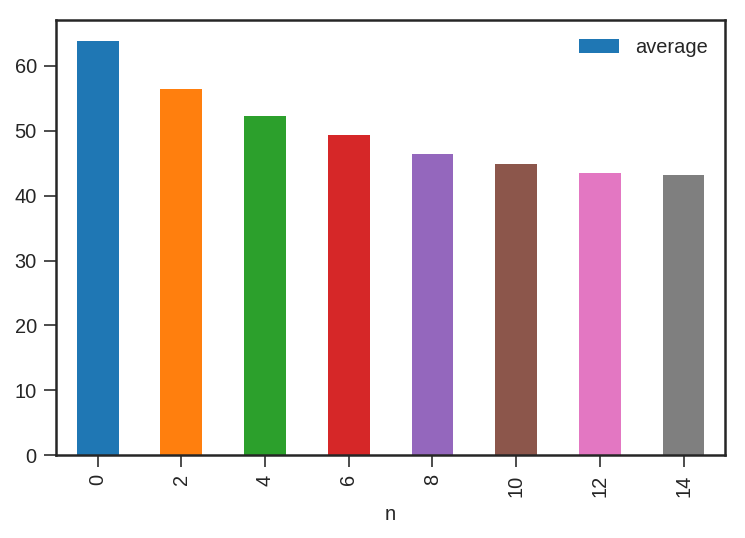

In [52]:
## Investigate the change in within-cluster distance across number of clusters.
## HINT: Use matplotlib's plot function to visualize this relationship.

n = [ x for x in range(numClusters) if x % 2 == 0 ]

cluster_df = pd.DataFrame( list(zip(average, n)) )
cluster_df.set_axis(['average', 'n'], axis=1, inplace=True)
cluster_df.plot.bar(x='n', y='average');

In [53]:
## Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population
## demographics data.
kmeans_pred_general = KMeans(n_clusters = numClusters).fit_predict(azdias_LowMisAttrs_dummies)

### Discussion 3.1: Apply Clustering to General Population
>- I used sklearn's KMeans class to perform k-means clustering on the PCA-transformed data and finally fitted the k-means model with number of clusters as 18 after investigating the change in within-cluster distance accross number of clusters..
>- As shown in the diagram above the curve changed at K = 16 and 18. Based on the [Elbow method (clustering)](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), we set the number of clusters (K) as 18 to segment the population. As we can see the Error Sum of Squares (SSE) tended to increase, instead of decrease, when the number of clusters, K, increased to 20.

### <a id='step_3_2'></a>  Step 3.2: Apply All Steps to the Customer Data
Now that we have clusters and cluster centers for the general population. It's time to see how the customer data maps on to those clusters. This is not a re-fitting all of the models to the customer data. I used the fits from the general population to clean, transform, and cluster the customer data. We can see how the general population fits apply to the customer data.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. The customer demographics data has similar meaning behind missing data patterns as the general demographics data.
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, No need to use a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
## Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")
customers.shape

(191652, 85)

####  Inspect  Customers demographics data

In [55]:
## Collect categorical attributes of feat_info into a list: 
catAttrs = feat_info[ feat_info["type"] == "categorical" ]
catAttrs_l = [i for i in catAttrs.attribute]

## Seperating Multi_level vs Binary categorical attributs:
mLvl_CatAttrs_l = []
bLvl_CatAttrs_l = []

for feature in catAttrs_l:

  if feature in colOutliers:
    continue

  if len( customers[feature].value_counts() ) > 2:
    mLvl_CatAttrs_l.append(feature)

  else:
    bLvl_CatAttrs_l.append(feature)


## Find mixed-type columns in a dataframe:
mixedAttrs = feat_info[ feat_info["type"] == "mixed" ]
mixedAttrs_l = [i for i in mixedAttrs.attribute]

colNames_customers = getColNames(customers)

mixedColNames_l = []
for col in colNames_customers:

  if col in colOutliers:
    continue

  if col in mixedAttrs_l:
    mixedColNames_l.append(col)
    
## Demonstrating:
print("Total: {} Multi-level Categorical attributes;\n{}\n".format(len(mLvl_CatAttrs_l), mLvl_CatAttrs_l))

print("Total: {} Binary Categorical attributes;\n{}\n".format(len(bLvl_CatAttrs_l), bLvl_CatAttrs_l)) 

print("Total: {} Mixed-Type Categorical attributes;\n{}\n".format(len(mixedColNames_l), mixedColNames_l)) 

Total: 14 Multi-level Categorical attributes;
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Total: 4 Binary Categorical attributes;
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

Total: 6 Mixed-Type Categorical attributes;
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']



In [56]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data,
## obtaining cluster predictions for the customer demographics data.

## Preprocessing - Data Cleansing 
custLowDummies = clean_data(customers)
custLowDummies.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


'CAMEO_INTL_2015'


(114949, 26)

In [57]:
## Imputing missing values with the mode
custLowDummies[list(custLowDummies.columns)] = \
    custLowDummies[list(custLowDummies.columns)].fillna(custLowDummies.mode().iloc[0])

In [58]:
## Apply feature scaling to the customer data.
scaler = StandardScaler()
custLowDummies[list(custLowDummies.columns)] = scaler.fit_transform(custLowDummies[list(custLowDummies.columns)])

In [59]:
## Apply PCA to the customer data while selecting for number of components to retain.

## numPCs = 30  ## ValueError: n_components=30 must be between 0 and n_features=26 with svd_solver='full'

numPCs = 30 if custLowDummies.shape[1] > 30 else custLowDummies.shape[1]

pca1 = PCA(n_components = numPCs)
custLowDummies_pca = pca1.fit_transform(custLowDummies)

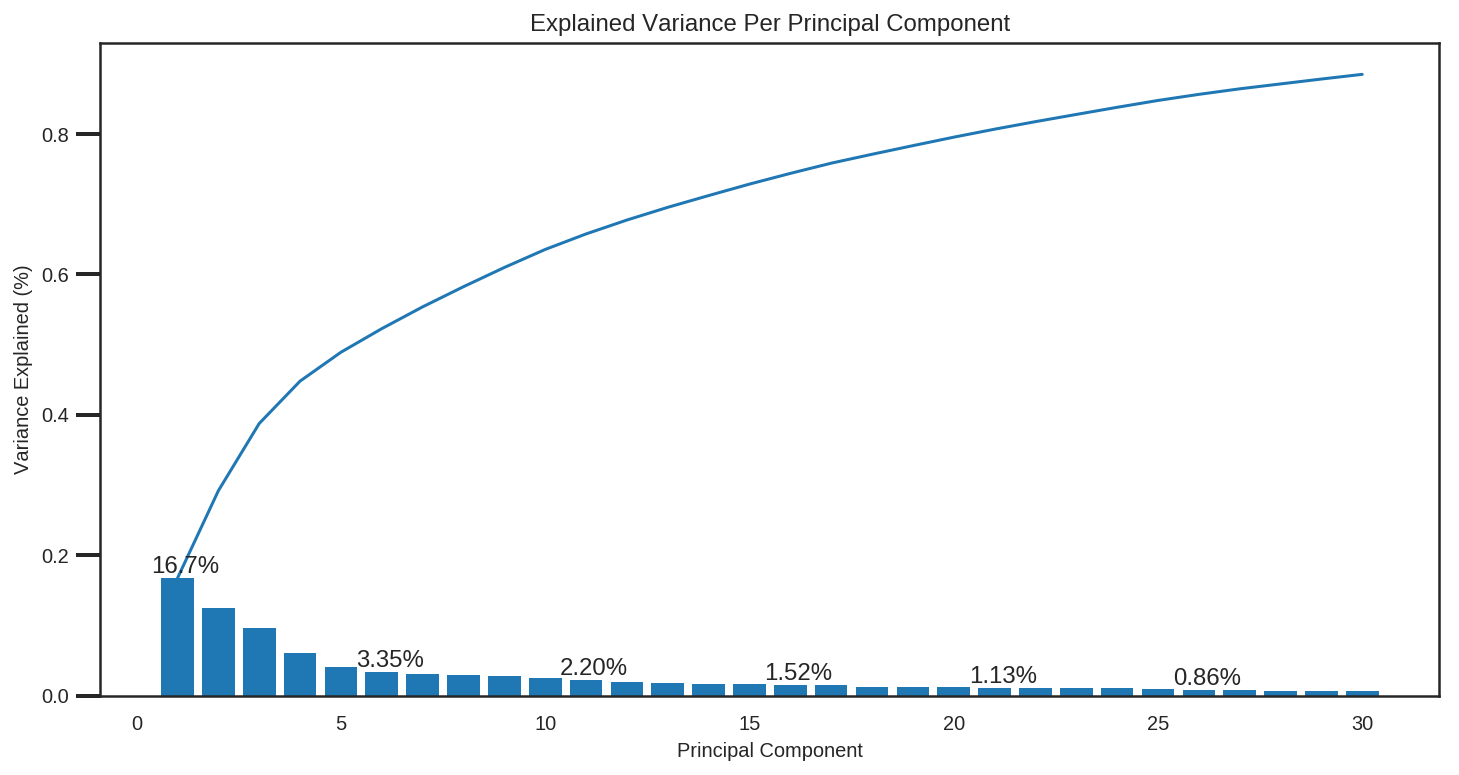

In [60]:
screen_plot(custLowDummies_pca)

In [61]:
## fit the k-means model with the selected number of clusters and obtain cluster predictions for the customers data.
kmeans_pred_customers = KMeans(n_clusters = numClusters).fit_predict(custLowDummies_pca)

### <a id='step_3_3'></a>  Step 3.3: Compare Customer Data to Demographics Data
At this point, the data based on demographics of the general population of Germany has been clustered and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I compared the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis performed in step 1.1.3 of the project, where  separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [62]:
## Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for
## the general population.
Counter(kmeans_pred_general)

Counter({8: 5624,
         7: 20169,
         14: 46653,
         12: 51940,
         5: 36264,
         11: 46482,
         9: 53957,
         6: 45368,
         4: 43167,
         3: 56964,
         15: 22579,
         13: 41630,
         2: 54292,
         1: 47579,
         0: 33865,
         10: 36667,
         16: 2704,
         17: 20969})

In [63]:
Counter(kmeans_pred_customers)

Counter({17: 9534,
         15: 5645,
         12: 7966,
         4: 9025,
         3: 5717,
         13: 6634,
         6: 9122,
         16: 3268,
         8: 7302,
         7: 7293,
         9: 6533,
         2: 6258,
         11: 2540,
         14: 6473,
         1: 5967,
         5: 5592,
         0: 7518,
         10: 2562})

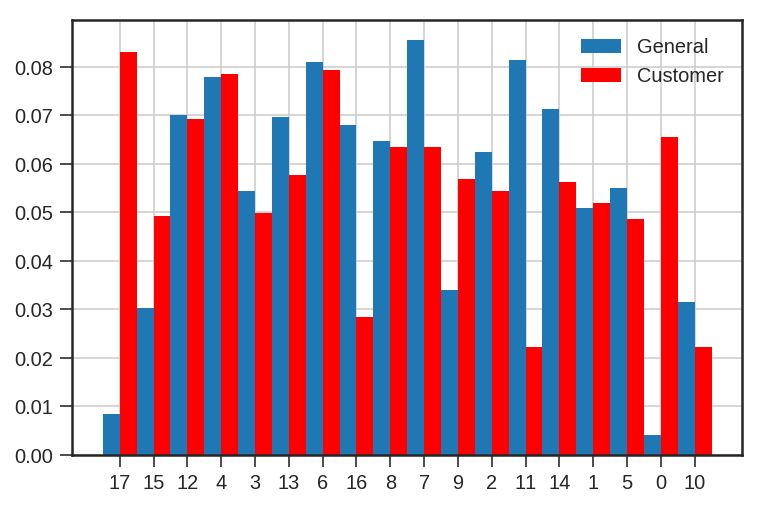

In [64]:
labels, values = zip(*Counter(kmeans_pred_customers).items())

v=list(values)
v[:] = [x / len(kmeans_pred_customers) for x in v]

indexes = np.arange(len(labels))
width = .5

labels1, values1 = zip(*Counter(kmeans_pred_general).items())

v1=list(values1)
v1[:] = [x/len(kmeans_pred_general) for x in v1]

indexes1 = np.arange(len(labels))

plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper right')
plt.grid()
plt.show()

From the above plot, in 0, 15, and 17 clusters, proportion of data is overpresented for customer compared to general population **AND** in 2, 3, 7, 11, and 13 clusters, proportion of data  is underpresented for customer compared to general population.

In [65]:
#Function for printing the top feature
def top_feature(numClusters, pca, df):
  print("Top feature for n_clusters:{}  is {} ".format(numClusters, getFeatureWeights(numClusters, pca, df).index[0]))

In [68]:
## What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general
## population?
top_feature(0, pca1, custLowDummies)
top_feature(15, pca1, custLowDummies)
top_feature(17, pca1, custLowDummies)

Top feature for n_clusters:0  is ANREDE_KZ_2 
Top feature for n_clusters:15  is FINANZ_SPARER 
Top feature for n_clusters:17  is FINANZ_HAUSBAUER 


>- ANREDE_KZ_2      - implies they are younger, i.e. higher on the year of their birth.
>- FINANZ_SPARER    - tells the levels of affinity on the "materialistic" personality type
>- FINANZ_HAUSBAUER - implies they care very much about home ownership

In [69]:
## What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general
## population?
top_feature(2, pca1, custLowDummies)
top_feature(3, pca1, custLowDummies)
top_feature(7, pca1, custLowDummies)
top_feature(11, pca1, custLowDummies)
top_feature(13, pca1, custLowDummies)

Top feature for n_clusters:2  is GREEN_AVANTGARDE_1 
Top feature for n_clusters:3  is GREEN_AVANTGARDE_1 
Top feature for n_clusters:7  is SEMIO_SOZ 
Top feature for n_clusters:11  is SEMIO_LUST 
Top feature for n_clusters:13  is SEMIO_FAM 


>- GREEN_AVANTGARDE_1  - implies they are member of green avantgarde
>- SEMIO_SOZ           - implies they are Not very socially-minded personality trait
>- SEMIO_LUST          - implies they are Not sensual-minded
>- SEMIO_FAM           - implies they are Not very family minded

### Discussion 3.3: Compare Customer Data to Demographics Data
>This mail-order company is popular among younger folks with materialistic personality type.

>Whereas this mail-order company is less popular among female in general, for those who are members of green avantgarde, i.e. for those sensitive on environmental sustainability, and for those who are more critical reserved on their health.

## <a id='references'></a> References:
### Challenges and Solutions
- SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame - [How to deal with SettingWithCopyWarning in Pandas?](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)
- [Use Unsupervised Machine Learning To Find Potential Buyers of Your Products](https://towardsdatascience.com/use-unsupervised-machine-learning-to-find-potential-buyers-of-your-products-cd75edaeefc7)
- [Blog: Loving Data Analysis by Brund Yang](http://www.ai-dataanalysis.com/content/images/files/Identify_Customer_Segments.html)
- [Rakesh Kumar Tiwary GitHub](https://github.com/Rakesh9998)